<a href="https://colab.research.google.com/github/wnaely/Fashion-MNIST/blob/main/notebooks/03_vae/02_vae_fashion/vae_fashion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# üëñ Î≥ÄÏù¥Ìòï Ïò§ÌÜ†Ïù∏ÏΩîÎçî - Ìå®ÏÖò MNIST

Ïù¥ ÎÖ∏Ìä∏Î∂ÅÏóêÏÑúÎäî Ìå®ÏÖò MNIST Îç∞Ïù¥ÌÑ∞ÏÖãÏúºÎ°ú Î≥ÄÏù¥Ìòï Ïò§ÌÜ†Ïù∏ÏΩîÎçîÎ•º ÌõàÎ†®Ìï©ÎãàÎã§.

In [47]:
import sys

# ÏΩîÎû©Ïùò Í≤ΩÏö∞ ÍπÉÌóàÎ∏å Ï†ÄÏû•ÏÜåÎ°úÎ∂ÄÌÑ∞ utils.pyÎ•º Îã§Ïö¥Î°úÎìú Ìï©ÎãàÎã§.
if 'google.colab' in sys.modules:
    !wget https://raw.githubusercontent.com/rickiepark/Generative_Deep_Learning_2nd_Edition/main/notebooks/utils.py
    !mkdir -p notebooks
    !mv utils.py notebooks

--2025-10-28 11:16:00--  https://raw.githubusercontent.com/rickiepark/Generative_Deep_Learning_2nd_Edition/main/notebooks/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 771 [text/plain]
Saving to: ‚Äòutils.py‚Äô

utils.py            100%[===================>]     771  --.-KB/s    in 0s      

2025-10-28 11:16:00 (61.3 MB/s) - ‚Äòutils.py‚Äô saved [771/771]



Ïù¥ ÏΩîÎìúÎäî ÏºÄÎùºÏä§ Ïõπ ÏÇ¨Ïù¥Ìä∏Ïóê ÏûàÎäî ÌîÑÎûëÏÜåÏôÄ ÏàÑÎ†à(Francois Chollet)Í∞Ä ÎßåÎì† ÌõåÎ•≠Ìïú [VAE ÌäúÌÜ†Î¶¨Ïñº](https://keras.io/examples/generative/vae/)ÏùÑ Ï∞∏Í≥†ÌñàÏäµÎãàÎã§.

In [48]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import (
    layers,
    models,
    datasets,
    callbacks,
    losses,
    optimizers,
    metrics,
)

from scipy.stats import norm

from notebooks.utils import display

## 0. ÌååÎùºÎØ∏ÌÑ∞ <a name="parameters"></a>

In [49]:
IMAGE_SIZE = 32
BATCH_SIZE = 100
VALIDATION_SPLIT = 0.2
EMBEDDING_DIM = 2
EPOCHS = 5
BETA = 500

## 1. Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑ <a name="prepare"></a>

In [50]:
# Îç∞Ïù¥ÌÑ∞ Î°úÎìú
(x_train, y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()

In [51]:
# Îç∞Ïù¥ÌÑ∞ Ï†ÑÏ≤òÎ¶¨
def preprocess(imgs):
    """
    Ïù¥ÎØ∏ÏßÄ Ï†ïÍ∑úÌôî Î∞è ÌÅ¨Í∏∞ Î≥ÄÍ≤Ω
    """
    imgs = imgs.astype("float32") / 255.0
    imgs = np.pad(imgs, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)
    imgs = np.expand_dims(imgs, -1)
    return imgs


x_train = preprocess(x_train)
x_test = preprocess(x_test)

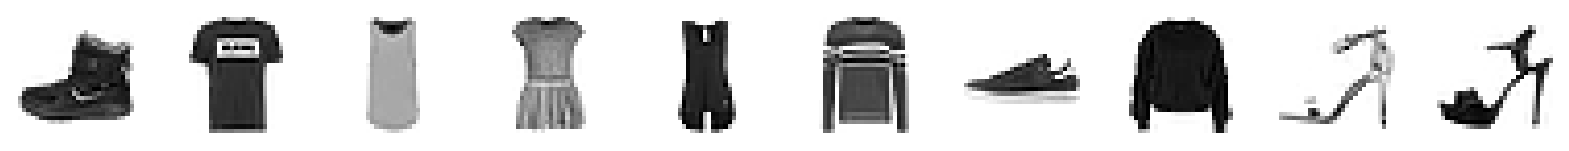

In [52]:
# ÌõàÎ†® ÏÑ∏Ìä∏Ïùò ÏùºÎ∂Ä ÏùòÎ•ò Ìï≠Î™© ÌëúÏãú
display(x_train)

## 2. Î≥ÄÏù¥Ìòï Ïò§ÌÜ†Ïù∏ÏΩîÎçî ÎßåÎì§Í∏∞ <a name="build"></a>

In [53]:
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [54]:
# Ïù∏ÏΩîÎçî
encoder_input = layers.Input(
    shape=(IMAGE_SIZE, IMAGE_SIZE, 1), name="encoder_input"
)
x = layers.Conv2D(32, (3, 3), strides=2, activation="relu", padding="same")(
    encoder_input
)
x = layers.Conv2D(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(128, (3, 3), strides=2, activation="relu", padding="same")(x)
shape_before_flattening = K.int_shape(x)[1:]  # ÎîîÏΩîÎçîÏóê ÌïÑÏöîÌï©ÎãàÎã§!

x = layers.Flatten()(x)
z_mean = layers.Dense(EMBEDDING_DIM, name="z_mean")(x)
z_log_var = layers.Dense(EMBEDDING_DIM, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder = models.Model(encoder_input, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)        ‚îÉ Output Shape      ‚îÉ    Param # ‚îÉ Connected to      ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ encoder_input       ‚îÇ (None, 32, 32, 1) ‚îÇ          0 ‚îÇ -                 ‚îÇ
‚îÇ (InputLayer)        ‚îÇ                   ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d_9 (Conv2D)   ‚îÇ (None, 16, 16,    ‚îÇ        320 ‚îÇ encoder_input[0]‚Ä¶ ‚îÇ
‚îÇ                     ‚îÇ 32)               ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d_10 (Conv2D)  ‚îÇ (None, 8, 8, 64)  ‚îÇ     18,496 ‚îÇ conv2d_9[0][0]    ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d_11 (Conv2D)  ‚îÇ (None, 4, 4, 128) ‚îÇ     73,856 ‚îÇ conv2d_10[0][0]   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ flatten_3 (Flatten) ‚îÇ (None, 2048)      ‚îÇ          0 ‚îÇ conv2d_11[0][0]   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ z_mean (Dense)      ‚îÇ (None, 2)         ‚îÇ      4,098 ‚îÇ flatten_3[0][0]   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ z_log_var (Dense)   ‚îÇ (None, 2)         ‚îÇ      4,098 ‚îÇ flatten_3[0][0]   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ sampling_3          ‚îÇ (None, 2)         ‚îÇ          0 ‚îÇ z_mean[0][0],     ‚îÇ
‚îÇ (Sampling)          ‚îÇ                   ‚îÇ            ‚îÇ z_log_var[0][0]   ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 100,868 (394.02 KB)

 Trainable params: 100,868 (394.02 KB)

 Non-trainable params: 0 (0.00 B)

In [55]:
# ÎîîÏΩîÎçî
decoder_input = layers.Input(shape=(EMBEDDING_DIM,), name="decoder_input")
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(
    128, (3, 3), strides=2, activation="relu", padding="same"
)(x)
x = layers.Conv2DTranspose(
    64, (3, 3), strides=2, activation="relu", padding="same"
)(x)
x = layers.Conv2DTranspose(
    32, (3, 3), strides=2, activation="relu", padding="same"
)(x)
decoder_output = layers.Conv2D(
    1,
    (3, 3),
    strides=1,
    activation="sigmoid",
    padding="same",
    name="decoder_output",
)(x)

decoder = models.Model(decoder_input, decoder_output)
decoder.summary()

Model: "functional_3"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ decoder_input (InputLayer)      ‚îÇ (None, 2)              ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_3 (Dense)                 ‚îÇ (None, 2048)           ‚îÇ         6,144 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ reshape_3 (Reshape)             ‚îÇ (None, 4, 4, 128)      ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d_transpose_9              ‚îÇ (None, 8, 8, 128)      ‚îÇ       147,584 ‚îÇ
‚îÇ (Conv2DTranspose)               ‚îÇ                        ‚îÇ               ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d_transpose_10             ‚îÇ (None, 16, 16, 64)     ‚îÇ        73,792 ‚îÇ
‚îÇ (Conv2DTranspose)               ‚îÇ                        ‚îÇ               ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d_transpose_11             ‚îÇ (None, 32, 32, 32)     ‚îÇ        18,464 ‚îÇ
‚îÇ (Conv2DTranspose)               ‚îÇ                        ‚îÇ               ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ decoder_output (Conv2D)         ‚îÇ (None, 32, 32, 1)      ‚îÇ           289 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 246,273 (962.00 KB)

 Trainable params: 246,273 (962.00 KB)

 Non-trainable params: 0 (0.00 B)

In [56]:
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):
        """ÌäπÏ†ï ÏûÖÎ†•ÏóêÏÑú Î™®Îç∏ÏùÑ Ìò∏Ï∂úÌï©ÎãàÎã§."""
        z_mean, z_log_var, z = encoder(inputs)
        reconstruction = decoder(z)
        return z_mean, z_log_var, reconstruction

    def train_step(self, data):
        """ÌõàÎ†® Ïä§ÌÖùÏùÑ Ïã§ÌñâÌï©ÎãàÎã§."""
        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstruction = self(data)
            reconstruction_loss = tf.reduce_mean(
                BETA
                * losses.binary_crossentropy(
                    data, reconstruction, axis=(1, 2, 3)
                )
            )
            kl_loss = tf.reduce_mean(
                tf.reduce_sum(
                    -0.5
                    * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                    axis=1,
                )
            )
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        """Step run during validation."""
        if isinstance(data, tuple):
            data = data[0]

        z_mean, z_log_var, reconstruction = self(data)
        reconstruction_loss = tf.reduce_mean(
            BETA
            * losses.binary_crossentropy(data, reconstruction, axis=(1, 2, 3))
        )
        kl_loss = tf.reduce_mean(
            tf.reduce_sum(
                -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                axis=1,
            )
        )
        total_loss = reconstruction_loss + kl_loss

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

    def get_config(self):
        return {}

In [57]:
# Î≥ÄÏù¥Ìòï Ïò§ÌÜ†Ïù∏ÏΩîÎçî ÏÉùÏÑ±
vae = VAE(encoder, decoder)

## 3. Î≥ÄÏù¥Ìòï Ïò§ÌÜ†Ïù∏ÏΩîÎçî ÌõàÎ†® <a name="train"></a>

In [58]:
# Î≥ÄÏù¥Ìòï Ïò§ÌÜ†Ïù∏ÏΩîÎçî Ïª¥ÌååÏùº
optimizer = optimizers.Adam(learning_rate=0.0005)
vae.compile(optimizer=optimizer)

In [59]:
# Î™®Îç∏ Ï†ÄÏû• Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ ÏÉùÏÑ±
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint.keras",
    save_weights_only=False,
    save_freq="epoch",
    monitor="loss",
    mode="min",
    save_best_only=True,
    verbose=0,
)
tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")

In [61]:
vae.fit(
    x_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_data=(x_test, x_test),
    callbacks=[model_checkpoint_callback, tensorboard_callback],
)

Epoch 1/5
600/600 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 6s 10ms/step - kl_loss: 5.0271 - reconstruction_loss: 130.6590 - total_loss: 135.6861 - val_kl_loss: 4.9540 - val_loss: 138.4978 - val_reconstruction_loss: 133.5437
Epoch 2/5
600/600 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 6s 10ms/step - kl_loss: 5.0674 - reconstruction_loss: 128.9557 - total_loss: 134.0230 - val_kl_loss: 5.1653 - val_loss: 137.1754 - val_reconstruction_loss: 132.0101
Epoch 3/5
600/600 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 6s 10ms/step - kl_loss: 5.0979 - reconstruction_loss: 128.4367 - total_loss: 133.5346 - val_kl_loss: 5.3369 - val_loss: 136.0724 - val_reconstruction_loss: 130.7355
Epoch 4/5
600/600 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 6s 10ms/step - kl_loss: 5.1540 - reconstruction_loss: 127.7838 - total_loss: 132.9378 - val_kl_loss: 5.2824 - val_loss: 135.7918 - val_reconstruction_loss: 130.5095
Epoch 5/5
600/600 ‚îÅ‚îÅ

In [62]:
import os

# Create the directory if it doesn't exist
os.makedirs("./models", exist_ok=True)

# ÏµúÏ¢Ö Î™®Îç∏ Ï†ÄÏû•
vae.save("./models/vae.keras")
encoder.save("./models/encoder.keras")
decoder.save("./models/decoder.keras")

## 3. Î≥ÄÏù¥Ìòï Ïò§ÌÜ†Ïù∏ÏΩîÎçîÎ•º ÏÇ¨Ïö©Ìïú Ïû¨Íµ¨ÏÑ± <a name="reconstruct"></a>

In [63]:
# ÌÖåÏä§Ìä∏ÏÖãÏùò ÏùºÎ∂ÄÎ•º ÏÑ†ÌÉùÌï©ÎãàÎã§.
n_to_predict = 5000
example_images = x_test[:n_to_predict]
example_labels = y_test[:n_to_predict]

157/157 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 3s 10ms/step
Ïã§Ï†ú ÏùòÎ•ò ÏïÑÏù¥ÌÖú


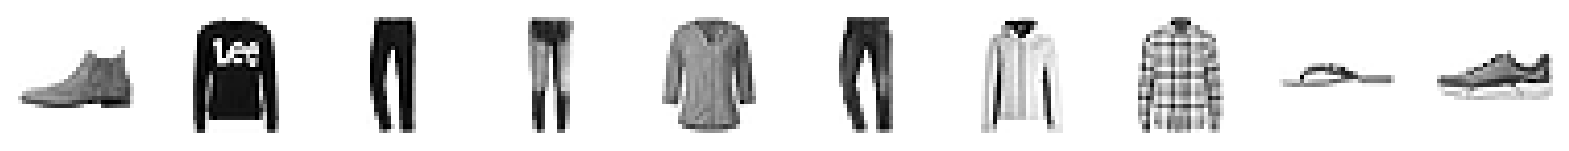

Ïû¨Íµ¨ÏÑ± Ïù¥ÎØ∏ÏßÄ


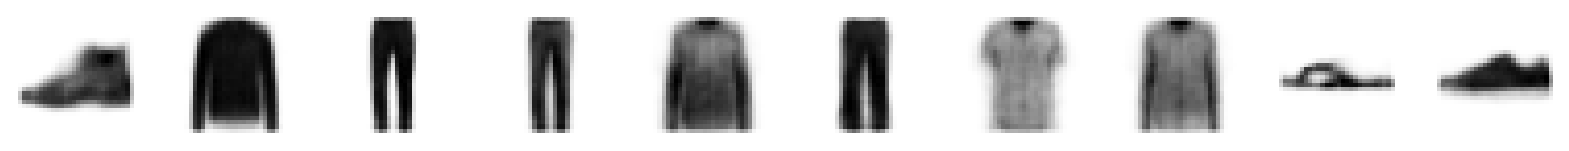

In [64]:
# Ïò§ÌÜ†Ïù∏ÏΩîÎçî ÏòàÏ∏°ÏùÑ ÎßåÎì§Í≥† Ï∂úÎ†•Ìï©ÎãàÎã§.
z_mean, z_log_var, reconstructions = vae.predict(example_images)
print("Ïã§Ï†ú ÏùòÎ•ò ÏïÑÏù¥ÌÖú")
display(example_images)
print("Ïû¨Íµ¨ÏÑ± Ïù¥ÎØ∏ÏßÄ")
display(reconstructions)

## 4. Ïù∏ÏΩîÎçîÎ•º ÏÇ¨Ïö©ÌïòÏó¨ ÏûÑÎ≤†Îî©ÌïòÍ∏∞ <a name="encode"></a>

In [65]:
# ÏòàÏ†ú Ïù¥ÎØ∏ÏßÄ Ïù∏ÏΩîÎî©
z_mean, z_var, z = encoder.predict(example_images)

157/157 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 5ms/step


In [66]:
# ÏûÑÎ≤†Îî©Ïùò Î™á Í∞ÄÏßÄ Ïòà
print(z[:10])

[[-0.12116174 -1.3593409 ]
 [ 1.1867498   0.57888407]
 [-1.5594893   2.6618874 ]
 [-2.0519693   1.1039608 ]
 [ 0.2015833   0.18965   ]
 [-1.1665407   1.5385891 ]
 [-0.52211756  0.21729472]
 [ 0.03849538  0.2897507 ]
 [-2.4714732  -0.8819358 ]
 [-1.4447532  -1.1983246 ]]


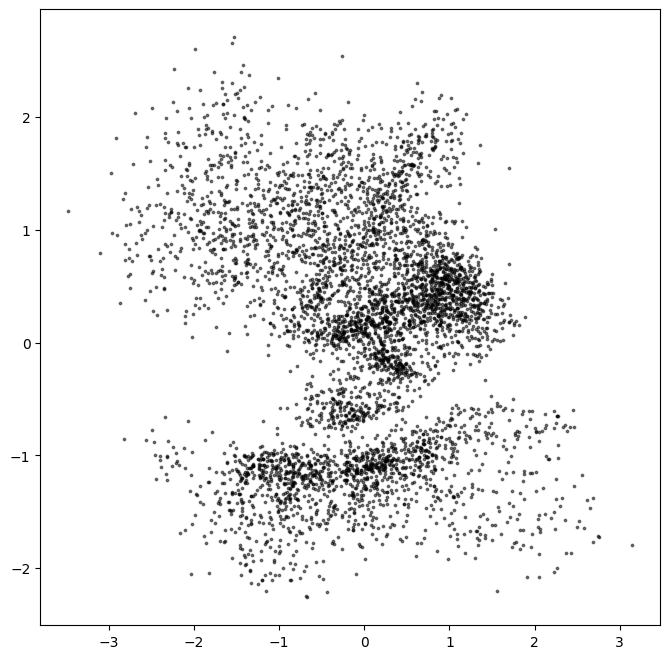

In [67]:
# 2D Í≥µÍ∞ÑÏóêÏÑú Ïù∏ÏΩîÎî©Îêú Ìè¨Ïù∏Ìä∏ ÌëúÏãú
figsize = 8

plt.figure(figsize=(figsize, figsize))
plt.scatter(z[:, 0], z[:, 1], c="black", alpha=0.5, s=3)
plt.show()

## 5. ÎîîÏΩîÎçîÎ•º ÏÇ¨Ïö©ÌïòÏó¨ ÏÉùÏÑ±ÌïòÍ∏∞ <a name="decode"></a>

In [68]:
# ÌëúÏ§Ä Ï†ïÍ∑ú Î∂ÑÌè¨ÏóêÏÑú Ïû†Ïû¨ Í≥µÍ∞ÑÏùò ÏùºÎ∂Ä Ìè¨Ïù∏Ìä∏Î•º ÏÉòÌîåÎßÅÌï©ÎãàÎã§.
grid_width, grid_height = (6, 3)
z_sample = np.random.normal(size=(grid_width * grid_height, 2))

In [69]:
# ÏÉòÌîåÎßÅÎêú Ìè¨Ïù∏Ìä∏ ÎîîÏΩîÎî©
reconstructions = decoder.predict(z_sample)

1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 561ms/step


In [70]:
# ÏõêÎ≥∏ ÏûÑÎ≤†Îî©Í≥º ÏÉòÌîåÎßÅÎêú ÏûÑÎ≤†Îî©ÏùÑ pÍ∞íÏúºÎ°ú Î≥ÄÌôòÌïòÍ∏∞
p = norm.cdf(z)
p_sample = norm.cdf(z_sample)

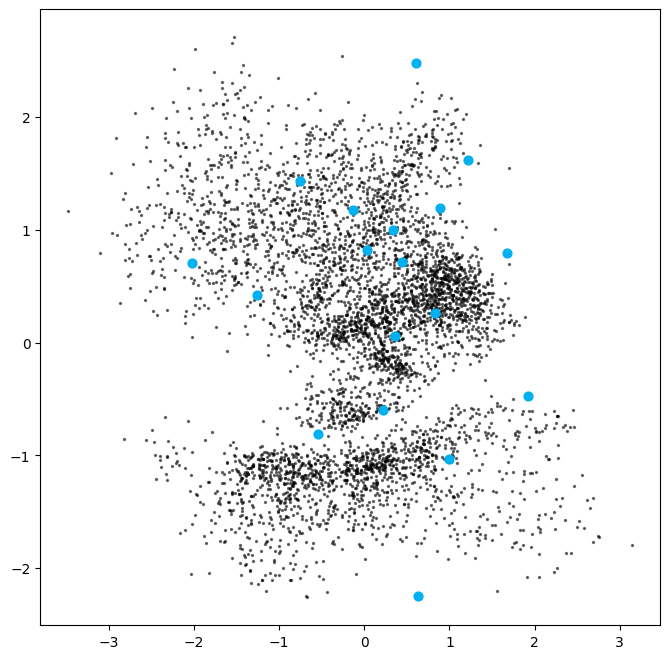

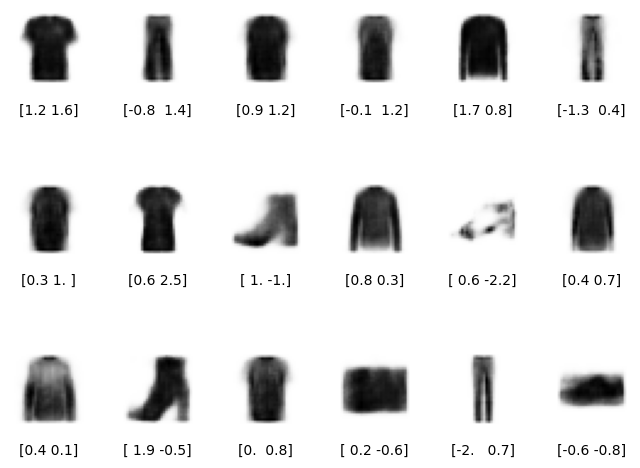

In [71]:
# Í∑∏ÎûòÌîÑÎ•º Í∑∏Î¶ΩÎãàÎã§....
figsize = 8
plt.figure(figsize=(figsize, figsize))

# ... ÏõêÎ≥∏ ÏûÑÎ≤†Îî© ...
plt.scatter(z[:, 0], z[:, 1], c="black", alpha=0.5, s=2)

# ... Ïû†Ïû¨ Í≥µÍ∞ÑÏóê ÏÉàÎ°ú ÏÉùÏÑ±Îêú Ìè¨Ïù∏Ìä∏
plt.scatter(z_sample[:, 0], z_sample[:, 1], c="#00B0F0", alpha=1, s=40)
plt.show()

# ÎîîÏΩîÎî©Îêú Ïù¥ÎØ∏ÏßÄ Í∑∏Î¶¨ÎìúÎ•º Ï∂îÍ∞ÄÌï©ÎãàÎã§.
fig = plt.figure(figsize=(figsize, grid_height * 2))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.text(
        0.5,
        -0.35,
        str(np.round(z_sample[i, :], 1)),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.imshow(reconstructions[i, :, :], cmap="Greys")

## 6. Ïû†Ïû¨ Í≥µÍ∞Ñ ÌÉêÏÉâ <a name="explore"></a>

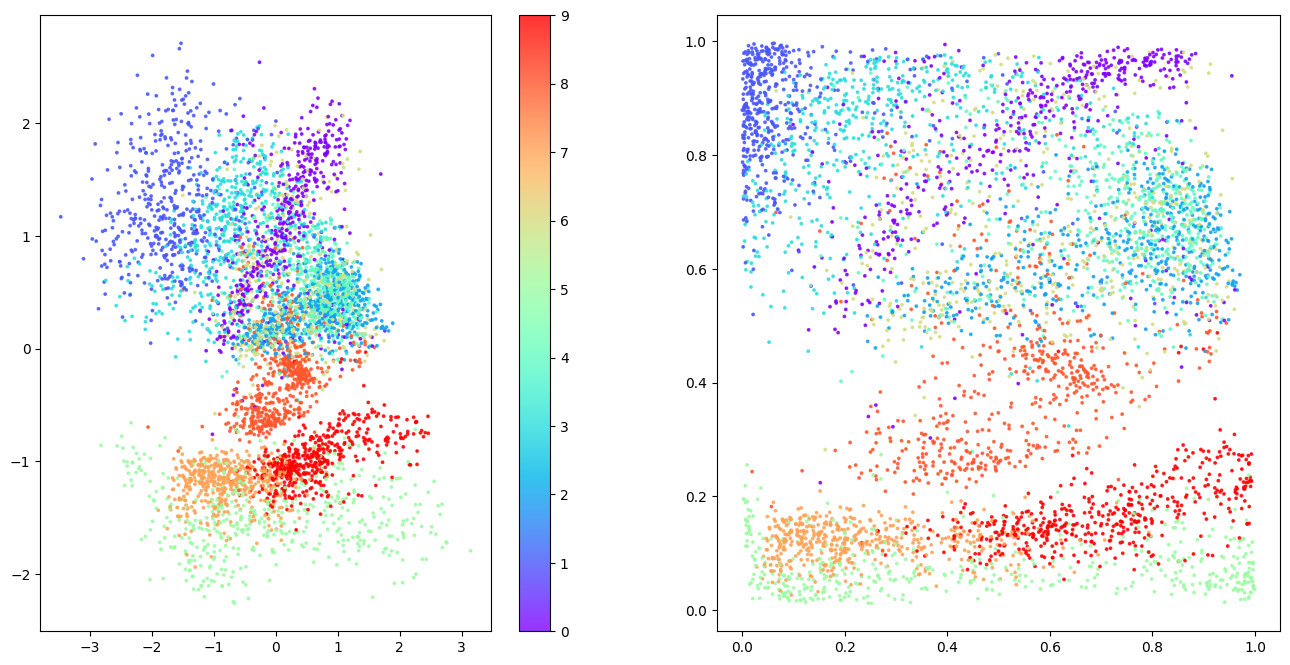

In [72]:
# Î†àÏù¥Î∏î(ÏùòÎ•ò Ï¢ÖÎ•ò)Ïóê Îî∞Îùº ÏûÑÎ≤†Îî©Ïóê ÏÉâÏÉÅÏùÑ ÏßÄÏ†ïÌï©ÎãàÎã§.
figsize = 8
fig = plt.figure(figsize=(figsize * 2, figsize))
ax = fig.add_subplot(1, 2, 1)
plot_1 = ax.scatter(
    z[:, 0], z[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=3
)
plt.colorbar(plot_1)
ax = fig.add_subplot(1, 2, 2)
plot_2 = ax.scatter(
    p[:, 0], p[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=3
)
plt.show()

| ID | Clothing Label |
| :- | :- |
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |

8/8 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 57ms/step


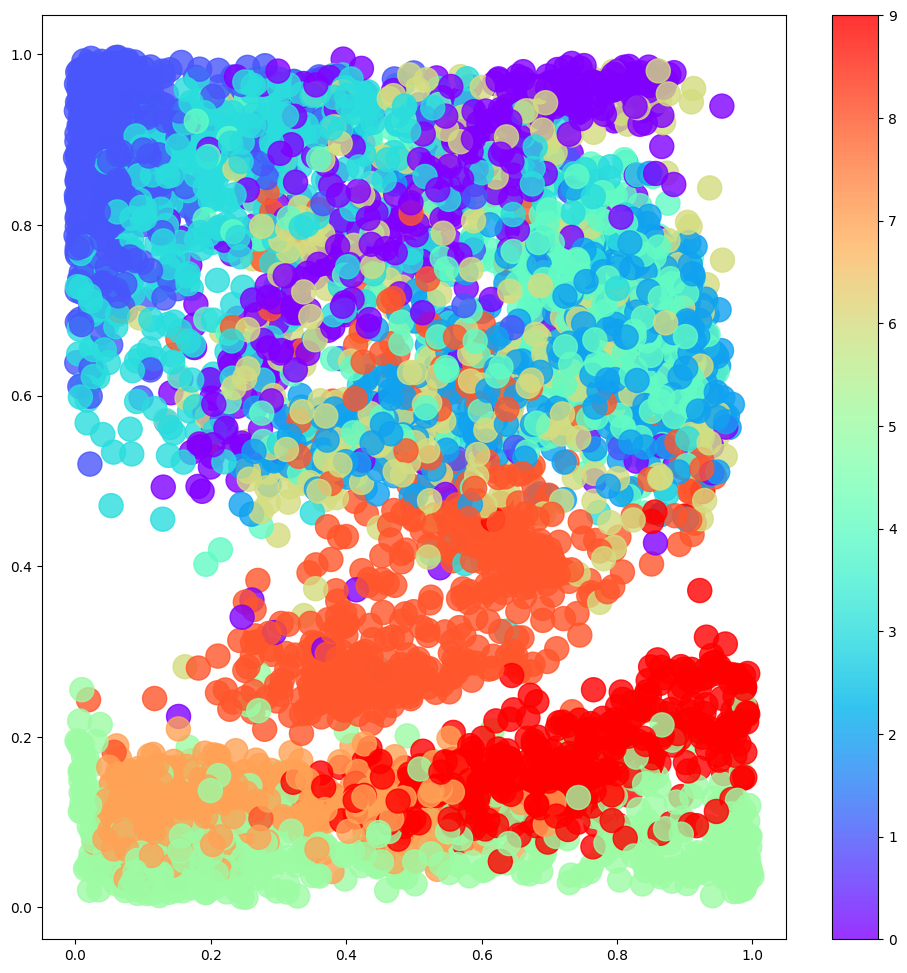

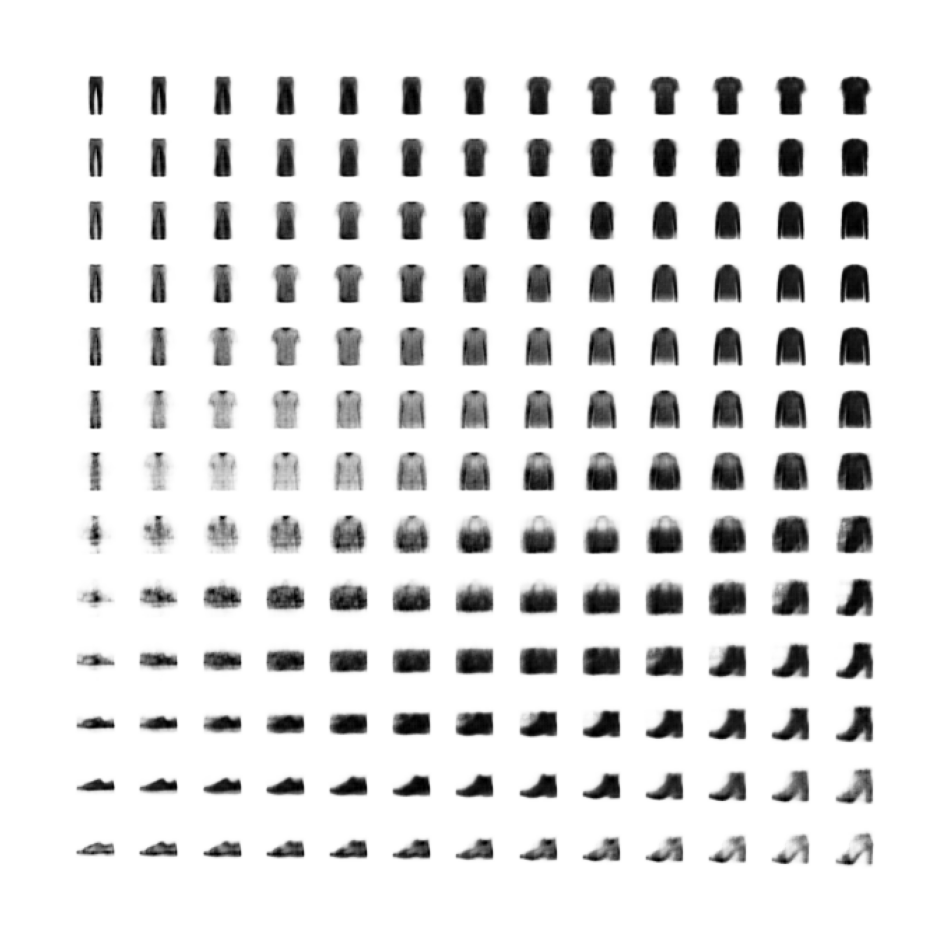

In [73]:
# Î†àÏù¥Î∏î(ÏùòÎ•ò Ï¢ÖÎ•ò)Ïóê Îî∞Îùº ÏûÑÎ≤†Îî©Ïóê ÏÉâÏÉÅÏùÑ ÏßÄÏ†ïÌï©ÎãàÎã§.
figsize = 12
grid_size = 15
plt.figure(figsize=(figsize, figsize))
plt.scatter(
    p[:, 0], p[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=300
)
plt.colorbar()

x = norm.ppf(np.linspace(0, 1, grid_size))
y = norm.ppf(np.linspace(1, 0, grid_size))
xv, yv = np.meshgrid(x, y)
xv = xv.flatten()
yv = yv.flatten()
grid = np.array(list(zip(xv, yv)))

reconstructions = decoder.predict(grid)
# plt.scatter(grid[:, 0], grid[:, 1], c="black", alpha=1, s=10)
plt.show()

fig = plt.figure(figsize=(figsize, figsize))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_size**2):
    ax = fig.add_subplot(grid_size, grid_size, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :], cmap="Greys")